In [1]:
DATA_PATH_RNN = 'C:/Users/денис/Desktop/AIChallenge/new-data'
DATA_PATH = 'C:/Users/денис/Desktop/AIChallenge/data'
TRAIN_DATA_PATH = f'{DATA_PATH_RNN}/train'
TASK_DATA_PATH = f'{DATA_PATH_RNN}/test'
TRAIN_FILENAME = f'{DATA_PATH}/train_gt.csv'
TASK_FILENAME = f'{DATA_PATH}/test.csv'

SAMPLE_RATE = 16000

In [2]:
import pandas as pd
from transformers import AutoFeatureExtractor, ASTForAudioClassification, Trainer, ASTConfig, ASTModel, TrainingArguments, ASTFeatureExtractor
from datasets import Dataset, load_dataset, Audio
import numpy as np
import evaluate
import torch

In [3]:
accuracy = evaluate.load("accuracy")

In [4]:
df = pd.read_csv(TRAIN_FILENAME, header=None, names=['audio', 'label'])
df['audio'] = TRAIN_DATA_PATH + "/" + df['audio']

dataset = Dataset.from_pandas(df).cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))

In [5]:
model_config = ASTConfig(
    hidden_size = 650, 
    num_hidden_layers = 10, 
    num_attention_heads = 10, 
    intermediate_size = 2500, 
    hidden_act = 'gelu', 
    initializer_range = 0.02, 
    layer_norm_eps = 2e-12, 
    patch_size = 16, 
    qkv_bias = True, 
    frequency_stride = 8, 
    time_stride = 8, 
    max_length = 1024, 
    num_mel_bins = 128
)

model = ASTForAudioClassification(model_config)

feature_extractor = ASTFeatureExtractor(feature_size=-1, sampling_rate=SAMPLE_RATE)

In [6]:
# Preprocess the dataset
def preprocess_function(examples):
    audio = examples["audio"]  # Adjust based on your dataset structure
    inputs = feature_extractor(audio["array"], return_tensors='np', sampling_rate=SAMPLE_RATE) 
    inputs['input_values'] = inputs['input_values'].reshape(1024, 128)
    return inputs

# Metrics computing while fine tuning
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [7]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"]).train_test_split(test_size=0.3) 

Map:   0%|          | 0/8803 [00:00<?, ? examples/s]

In [8]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 6162
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 2641
    })
})

In [11]:
training_arguments = TrainingArguments(
    output_dir="/ast_save",
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    # gradient_accumulation_steps=4, 
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    # warmup_ratio=0.1,
    # logging_steps=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

  0%|          | 0/1930 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
test = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
names = test['audio']
test['audio'] = TASK_DATA_PATH + "/" + test['audio']

dataset = Dataset.from_pandas(test).cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))

In [4]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("C:/ast_save")

In [7]:
resi = []
for tut in dataset:
    with torch.no_grad():
        resi.append(model(**feature_extractor(tut["audio"]["array"], sampling_rate=SAMPLE_RATE, return_tensors="pt", feature_size=-1)).logits)

In [8]:
import torch

resich = []

for i in resi:
    resich.append(torch.argmax(i).item())

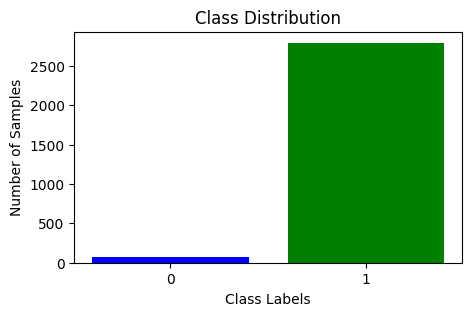

In [14]:
import matplotlib.pyplot as plt
a = 0
b = 0
for _ in resich:
    if _==1:
        a+=1
    else: 
        b+=1
class_counts = [b, a]
class_names = ['0', '1']
class_colors = ['blue', 'green']
plt.figure(figsize=(5, 3))
plt.bar(class_names, class_counts, color=class_colors)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [20]:
final_ast = pd.DataFrame({
    'names': names.tolist(),
    'labels': resich
})

In [21]:
final_ast.to_csv('final_ast.csv', header=None, index=False)